In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import wandb
import gc

import os

In [2]:
import sqlite3

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("TensorFlow is using the GPU \n", gpus)
else:
    print("No GPU detected.")
    
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow is using the GPU 
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
gc.collect()
tf.keras.backend.clear_session()

In [5]:
from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: Currently logged in as: emmdaz (emmdaz-zzz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# Carga de los datos 

df = pd.read_csv("/Plant-Pathology-Classificator/plant-pathology-2020-/train.csv")
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:


df["label"] = df[["healthy", "multiple_diseases", "rust", "scab"]].idxmax(axis=1)

df["filepath"] = df['image_id'].apply(lambda x: os.path.join("/Plant-Pathology-Classificator/plant-pathology-2020-/images", f'{x}.jpg'))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(df, test_size = 0.5, stratify = df["label"], random_state = 4)

X_test, X_val = train_test_split(X_temp, test_size = 0.4, stratify = X_temp["label"], random_state = 4)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 910
Validation size: 365
Test size: 546


In [9]:
mini_train, _ = train_test_split(X_train, test_size = 0.6, stratify = X_train["label"], random_state = 4)

mini_val, _ = train_test_split(X_val, test_size = 0.2, stratify = X_val["label"], random_state = 4)

print("Small training size:", len(mini_train))
print("Small val size:", len(mini_val))

Small training size: 364
Small val size: 292


In [10]:
datagen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30 ,          
    width_shift_range = 0.2,      
    height_shift_range = 0.2,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (0.7, 1.3),
    channel_shift_range = 30.0,
    fill_mode = "reflect")

datagen_test_and_val = ImageDataGenerator(rescale = 1./255, dtype = "float32")

In [11]:
train = datagen_train.flow_from_dataframe(
    dataframe = X_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = True,
    seed = 4
)

test = datagen_test_and_val.flow_from_dataframe(
    dataframe = X_test,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = False
)

val = datagen_test_and_val.flow_from_dataframe(
    dataframe = X_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 16
)

mini_train = datagen_train.flow_from_dataframe(
    dataframe = mini_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32
)

mini_val = datagen_test_and_val.flow_from_dataframe(
    dataframe = mini_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = True,
    seed = 4
)

Found 910 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.
Found 364 validated image filenames belonging to 4 classes.
Found 292 validated image filenames belonging to 4 classes.


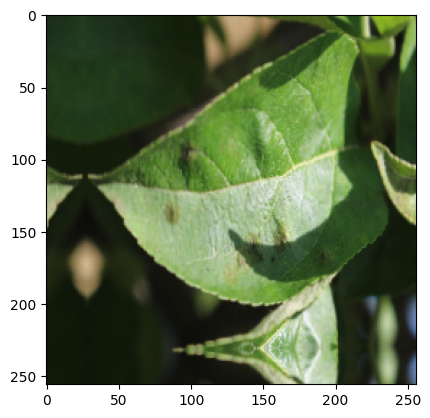

In [12]:
import matplotlib.pyplot as plt
img, _ = next(train)
plt.imshow(img[10])
plt.show()

In [13]:
# Función para los bloques residuales

def residual_block(x, kernel, kernel_size, activation, dropout, dropout_rate, regularizer, r_2):
        
    residual = x  
        
    if dropout == "y":
        # Camino "principal"
        x = layers.Conv2D(kernel, (kernel_size, kernel_size), padding = "same",
                              activation = activation)(x)
        x = layers.BatchNormalization()(x)
        
        # Capa intermedia Dropot
        x = layers.Dropout(dropout_rate)(x)
            
        # Capa lineal
        x = layers.Conv2D(kernel, (kernel_size, kernel_size), padding = "same")(x)
        x = layers.BatchNormalization()(x)
            
    else: 
        # Camino "principal"
        x = layers.Conv2D(kernel, (kernel_size, kernel_size), padding = "same",
                                  activation = activation, kernel_regularizer = regularizers.l2(r_2))(x)
        x = layers.BatchNormalization()(x)
                
        # Capa lineal
        x = layers.Conv2D(kernel, (kernel_size, kernel_size), padding = "same",
                                  kernel_regularizer = regularizers.l2(r_2))(x)
        x = layers.BatchNormalization()(x)
            
#     if x.shape[-1] != residual.shape[-1]:
#         residual = layers.Conv2D(filters = kernel, kernel_size = (1, 1),
#                                  strides=strides, padding = "same")(residual)
#         residual = layers.BatchNormalization()(residual)

    # Suma de la conexión residual
    x = layers.add([x, residual]) 
    x = layers.Activation(activation)(x)
        
    return x

In [14]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [15]:
def objective(trial):

    tf.keras.backend.clear_session()

    model = models.Sequential()
    inputs = layers.Input(shape=(256, 256, 3))
    # x = data_augmentation(inputs, training = True)
    
    #############################################################################################################
    
    # Optuna sugiere función de activación para todas las capas
    activation = "relu"
    
    # Optuna sugiere regularizador
    regularizer = "L2"
    r_2 = trial.suggest_float("regularizer_value_2", 1e-6, 3e-6, log = True)
    
    # Optuna sugiere el número de capas
    n_layers = trial.suggest_int("N_layers", 10, 15)
    
    # Optuna sugiere número de kernels y su tamaño en la primer capa convolucional
    
    kernel_1 = 10
    size_1 = trial.suggest_categorical("Kernel_Size_1", [2,7])
    
    # Optuna sugiere Learning Rate y Optimizador
    
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log = True)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    
                              
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
                              
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr)
    
    #############################################################################################################
    
    # Primera convolución
    x = layers.Conv2D(kernel_1, (size_1,size_1), padding = "same")(inputs)
    x = layers.Activation(activation)(x)
    x = layers.BatchNormalization()(x)
    
    kernel_per_layer = [kernel_1]
    kernel_size_per_layer = [size_1]
    
    # Optuna sugiere número de kernels su tamaño y función de activación; también sugiere Dropout
    # y regularizadores
    
    dropout_per_layer = []
    dropout_percentage_per_layer = []
    
    n_kernel =  trial.suggest_int("Kernels", 12,16)
    
    kernel_size = trial.suggest_categorical(f"Kernel_Size", [3,5])
    kernel_size_per_layer.append(kernel_size)
    
    for i in range(n_layers):
                              
        dropout = trial.suggest_categorical(f"Dropout_L{i+2}", ["y", "n"])
        dropout_per_layer.append(dropout)
                              
        dropout_rate = trial.suggest_float(f"Dropout_value_L{i+2}",0.1, 0.2)
        
        # Capa Convolucional i-ésima:
        
        # Se elige entre Dropout o un Regularizador
        if dropout == "y":
            
            dropout_percentage_per_layer.append(dropout_rate)
            
            ker = int(n_kernel * (2 ** (i // 2)))
            kernel_per_layer.append(ker)
            
            x = layers.Conv2D(ker, (kernel_size, kernel_size), strides = 2, padding = "same",
                              activation = activation)(x)
            x = layers.BatchNormalization()(x)
            
            x = residual_block(x, ker, kernel_size, activation, dropout, dropout_rate, regularizer, r_2)
            
        else:
            dropout_percentage_per_layer.append(0.0)

            ker = int(n_kernel * (2 ** (i // 2)))
            kernel_per_layer.append(ker)

            x = layers.Conv2D(ker, (kernel_size, kernel_size), strides = 2, padding = "same",
                                  activation = activation, kernel_regularizer = regularizers.l2(r_2))(x)
            x = layers.BatchNormalization()(x)

            x = residual_block(x, ker, kernel_size, activation, dropout, dropout_rate, regularizer, r_2)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
                              
    outputs = layers.Dense(4, activation = "softmax", dtype = "float32")(x)
        
    model = models.Model(inputs, outputs)
                              
    model.compile(
    optimizer = optimizer,
    loss = "categorical_crossentropy",
        metrics = ["accuracy"])
    
    #############################################################################################################

    wandb.init(
        project = "Plant-Pathology-Classificator-Conv2D-Residual-Trials-8.0",
        name = f"Trial_{trial.number}",
        reinit = True,
        config = {
            "kernel_1": kernel_1,
            "size_1": size_1,
            "activation": activation,
            "n_layers": n_layers,
            "n_kernel": n_kernel,
            "kernel_size": kernel_size,
            "kernel_per_layer": kernel_per_layer,
            "kernel_size_per_layer": kernel_size_per_layer,
            "regularizer": regularizer,
            "r_value2": r_2,
            "dropout_per_layer": dropout_per_layer,
            "dropout_percentage_per_layer": dropout_percentage_per_layer,
            "learning_rate": lr,
            "optimizer": optimizer_name,
        }
    )
    
    #############################################################################################################
                              
    early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)
    lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 5)
    
    #############################################################################################################
    """
    Creación del modelo
    """
    
    try:
        print(model.summary())
    
        history = model.fit(
            mini_train,
            validation_data = mini_val,
            epochs = 200,
            verbose = 1, 
            callbacks = [WandbMetricsLogger(log_freq = 5), early_stopping]
        )

        # val_loss = min(history.history["val_loss"])
        # train_loss = min(history.history["loss"])
        val_accuracy = max(history.history["val_accuracy"])
    
    except tf.errors.ResourceExhaustedError as e:
        print(f"Intento {trial.number} falló debido a: {e}")
        
        tf.keras.backend.clear_session()
        wandb.finish()
        gc.collect()
        
        return float("inf")

    except Exception as e:
        print(f"Intento {trial.number} falló. Unexpected error: {e}")
        
        tf.keras.backend.clear_session()
        wandb.finish()
        gc.collect()
        
        return float("inf")

    # Penalize overfitting
    
    # score = val_loss + 0.1 * (train_loss - val_loss)
    
    score = val_accuracy
    
    tf.keras.backend.clear_session()
    gc.collect()
    wandb.finish()

    return 1-score

In [ ]:
os.makedirs("/workspace/Optuna-Trials/Plant-Pathology-Classificator-Conv2D-Residual-Trials", exist_ok = True)

study = optuna.create_study(
    study_name = "Experimentos-Serie-8.0",
    direction = "minimize",
    storage = "sqlite:////workspace/Optuna-Trials/Plant-Pathology-Classificator-Conv2D-Residual-Trials/ResNet-Conv2D_study.db",
    load_if_exists = True
)

study.optimize(objective, n_trials = 200)

[I 2025-11-08 20:50:49,489] Using an existing study with name 'Experimentos-Serie-8.0' instead of creating a new one.
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 10  130         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 10  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 26)  104         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 26)   6110        ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 26)  104         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_1 (Dropout)            (None, 16, 16, 26)   0           ['batch_normalization_11[0][0]'] 
          

 activation_7 (Activation)      (None, 2, 2, 104)    0           ['add_6[0][0]']                  
                                                                                                  
 conv2d_22 (Conv2D)             (None, 1, 1, 104)    97448       ['activation_7[0][0]']           
                                                                                                  
 batch_normalization_22 (BatchN  (None, 1, 1, 104)   416         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_23 (Conv2D)             (None, 1, 1, 104)    97448       ['batch_normalization_22[0][0]'] 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 1, 1, 104)   416         ['conv2d_23[0][0]']              
 ormalizat

 add_10 (Add)                   (None, 1, 1, 416)    0           ['batch_normalization_33[0][0]', 
                                                                  'batch_normalization_31[0][0]'] 
                                                                                                  
 activation_11 (Activation)     (None, 1, 1, 416)    0           ['add_10[0][0]']                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 1, 1, 416)    1557920     ['activation_11[0][0]']          
                                                                                                  
 batch_normalization_34 (BatchN  (None, 1, 1, 416)   1664        ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_35

In [ ]:
print("Número de pruebas terminadas: ", len(study.trials))

trial = study.best_trial

print("Mejor intento: ", trial)

print("Valor: ", trial.value)
print("Hiperparámetros: ", trial.params)

In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank

In [ ]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)